In [0]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import os
import time

In [0]:
# Hyperparameters
num_epochs = 30
num_classes = 10
batch_size = 100
learning_rate = 1e-3

In [0]:
def get_data(path, num_workers):
  # CUFAR10 dataset
  # Before using, you should download the dataset to your local repository. Specify 'download' parameter
  # of train_data as True.
  train_data = torchvision.datasets.CIFAR10(root=path, train=True, transform=transforms.ToTensor(), download=True)
  test_data = torchvision.datasets.CIFAR10(root=path, train=False, transform=transforms.ToTensor())

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
  test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
  return train_loader, test_loader

# All classes of images in dataset
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
train_data, test_data = get_data("data", 2)

Files already downloaded and verified


In [0]:
# Show the number of images equals to batch_size
def imshow(img):
    img = img / 2 + 0.3
    npimg = img.numpy()
    plt.figure(figsize=(8, 3))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

  cat  horse  truck   ship    dog


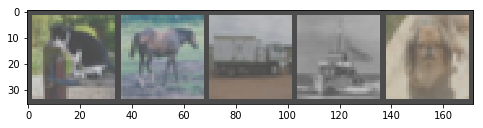

In [19]:
# Checking out the dataset 
dataiter = iter(train_data)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:5]))
print("  ".join('%5s' % classes[labels[j]] for j in range(5)))

In [0]:
# Convolutional neural network (CNN), we will use two convolutional layers
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Convolutional and pooling layers
        self.cl1 = self.create_conv_layer(3, 30)
        self.cl2 = self.create_conv_layer(30, 30)
        self.cl3 = self.create_conv_layer(30, 30)
        
        # Dropout and fully connected layers
        self.drop_out = nn.Dropout()
        self.fc1 = self.create_fc_layer(4 * 4 * 30, 300)
        self.fc2 = self.create_fc_layer(300, 350)
        self.fc3 = nn.Linear(350, num_classes)
    
    # Creation of convolutional block: convolutional layer, ReLU activation function, 2d BatchNorming and MaxPooling
    def create_conv_layer(self, in_features, out_features):
        self.layer = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(out_features),
            nn.MaxPool2d(2, 2),
        )
        return self.layer
    
    # Creation of fully connected layer: Linear layer, Tanh activation function and 1d BatchNorming
    def create_fc_layer(self, in_features, out_features):
        self.layer = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.ReLU(),
            nn.BatchNorm1d(out_features),
        )
        return self.layer
    
    # Forward pass
    def forward(self, x):
        x = self.cl1(x)
        x = self.cl2(x)
        x = self.cl3(x)
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [0]:
model = CNN()

In [0]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

# Train our model
def train(model, epochs, learning_rate):
    start = time.time()
    total = len(train_data)
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_data):
            images, labels = Variable(images), Variable(labels)
            
            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            optimizer.zero_grad() # Zero gradient value
            loss.backward() # Backward pass
            optimizer.step() # Update our weights
            
            # Visual information
            if (i+1) % 100 == 0:
                print (f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{total}], Loss: {round(loss.item(), 4)}")
    all_time = round((time.time() - start) / 60, 2)
    print(f"\nTime of training: {all_time} minutes")

In [0]:
# Test our model
def validate_model(model, data):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        if len(data) > 100:
          print(f"Accuracy of the model on train data: {round(correct / total * 100, 2)}%")
        elif len(data) == 100:
          print(f"Accuracy of the model on test data: {round(correct / total * 100, 2)}%")

## Training

In [11]:
train(model, num_epochs, learning_rate)

Epoch [1/30], Step [100/500], Loss: 1.6275
Epoch [1/30], Step [200/500], Loss: 1.3661
Epoch [1/30], Step [300/500], Loss: 1.2561
Epoch [1/30], Step [400/500], Loss: 1.2847
Epoch [1/30], Step [500/500], Loss: 1.3563
Epoch [2/30], Step [100/500], Loss: 0.9952
Epoch [2/30], Step [200/500], Loss: 1.1471
Epoch [2/30], Step [300/500], Loss: 1.0452
Epoch [2/30], Step [400/500], Loss: 0.9985
Epoch [2/30], Step [500/500], Loss: 1.0897
Epoch [3/30], Step [100/500], Loss: 1.0662
Epoch [3/30], Step [200/500], Loss: 0.9576
Epoch [3/30], Step [300/500], Loss: 0.9294
Epoch [3/30], Step [400/500], Loss: 1.1192
Epoch [3/30], Step [500/500], Loss: 1.0863
Epoch [4/30], Step [100/500], Loss: 0.8388
Epoch [4/30], Step [200/500], Loss: 0.9298
Epoch [4/30], Step [300/500], Loss: 0.8975
Epoch [4/30], Step [400/500], Loss: 0.9907
Epoch [4/30], Step [500/500], Loss: 0.9268
Epoch [5/30], Step [100/500], Loss: 0.7009
Epoch [5/30], Step [200/500], Loss: 0.852
Epoch [5/30], Step [300/500], Loss: 0.7982
Epoch [5/30]

It is always interesting to see how fast the loss is changing its value. Let's check it :)

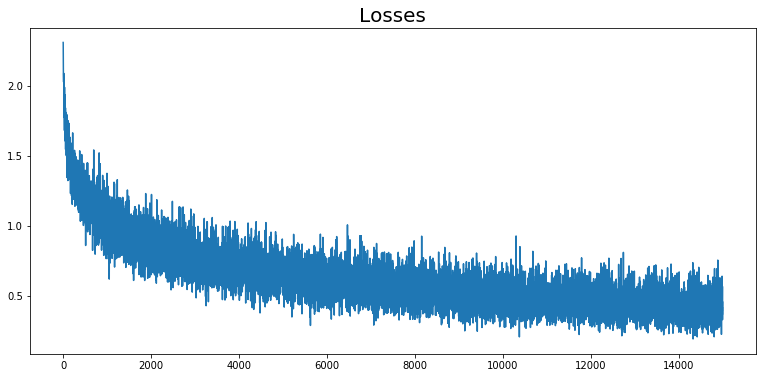

In [12]:
plt.figure(figsize=(13, 6))
plt.plot(losses)
plt.title("Losses", fontsize=20)
plt.show()

## Let's test it!

In [13]:
validate_model(model, train_data)

Accuracy of the model on train data: 93.07%


In [17]:
validate_model(model, test_data)

Accuracy of the model on test data: 78.98%


#### So, accuracy is actually nice, cause difference between train and test datatsets accuracy is pretty small, i.e. model is not overfited. Now, let's try to predict class by image

In [0]:
dataiter = iter(test_data)

Actual classes:   dog   car  ship horse   car
Predicted classes:   dog plane  ship horse   car


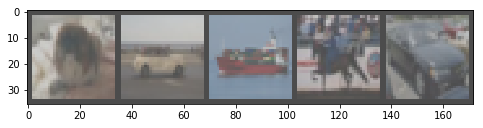

In [25]:
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:5]))

outputs = model(images)
_, predicted = torch.max(outputs.data, 1)
print("Actual classes:", " ".join('%5s' % classes[labels[j]] for j in range(5)))
print("Predicted classes:", " ".join('%5s' % classes[predicted[j]] for j in range(5)))

## After some tests, i can surely say that model performs excellent results.
### The most common case is 4/5 correct answers!

In [0]:
 def save_model(path):
    torch.save(model.state_dict(), path)
    print("Model saved!")